In [1]:
#add spex templates to selection function
#select the highest SNR spectra of each spectral type i.e 

In [2]:
import splat
import wisps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import numba
%matplotlib inline

In [3]:
splat.initializeStandards()

In [4]:
spectra=pd.read_pickle(wisps.OUTPUT_FILES+'/l_t_dwarfs.pkl')
spts=np.array([splat.typeToNum(x) for x in np.linspace(20, 40, 21)])

In [5]:
spts

array(['L0.0', 'L1.0', 'L2.0', 'L3.0', 'L4.0', 'L5.0', 'L6.0', 'L7.0',
       'L8.0', 'L9.0', 'T0.0', 'T1.0', 'T2.0', 'T3.0', 'T4.0', 'T5.0',
       'T6.0', 'T7.0', 'T8.0', 'T9.0', 'Y0.0'], dtype='<U4')

In [6]:
splat_db=splat.searchLibrary(vlm=True, giant=False)

In [7]:
df=splat_db[splat_db.SPEX_TYPE.isin(spts)]

In [8]:
#

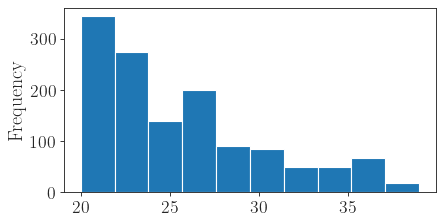

In [9]:
#nned to add T4s
df.SPEX_TYPE.apply(splat.typeToNum).plot(kind='hist', bins=10)

In [10]:
g=df.sort_values('MEDIAN_SNR',ascending=False).groupby('SPEX_TYPE')

In [11]:
#g[['SPEX_TYPE', 'MEDIAN_SNR']].SPEX_TYPE.apply(splat.typeToNum).plot(kind='hist')

In [13]:
#g1=g[~g.SPEX_TYPE.apply(splat.typeToNum).apply(lambda x: np.isnan(x))]

In [15]:
files=g

In [ ]:
#files=files[files.SPEX_TYPE.isin(miss_spts)]

In [16]:
def get_vals(dic):
    l=pd.Series(dic).values
    return  np.array([*l])[:,0]

MAGS=np.array([get_vals(s.mags) for s in spectra])
SNRS=np.array([s.snr['snr1'] for s in spectra])
SPTS=np.array([wisps.make_spt_number(s.spectral_type) for s in spectra])

In [17]:
import astropy.units as u

In [18]:
def find_nearest(array, value):
    #find the nearest value in an array
    print(value)
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

@numba.jit
def create_splat_source(filename, ra, dec):
    #create a wisps spectrum
    #retrieve splat spectrum
    
    splat_s=splat.getSpectrum(filename=filename)[0]
    spt=splat.typeToNum(splat_s.spex_type)
    
    #create a source object
    s=wisps.Spectrum( 
                   wave=splat_s.wave.value, 
                   flux=splat_s.flux.value,
                  noise=splat_s.noise.value)
    
    
    #assign the closest spectrum in terms of spectral type the
    idx=find_nearest(SPTS, spt)
    snr=SNRS[idx]
    
    m=MAGS[idx]-2.5*np.log10(s.snr['snr1']/snr)
    
    mags={'F110W':(m[0],0.01),
         'F140W': (m[1],0.01),
          'F160W':(m[2],0.01)}
    #s._mags=mags
    #s.ra=ra
    #s.dec=dec
    #s._calculate_distance()
    #s.original = copy.deepcopy(s)
    #s.spectral_type=spt
    #print ('spectral type {}'.format(s.spectral_type))
    s.normalize()
    
    return s

In [19]:
import astropy.units as u

In [20]:
%%capture
news=[create_splat_source(row['DATA_FILE'], row['RA']*u.deg, row['DEC']*u.deg) for index, row in  files.iterrows()]

AttributeError: Cannot access callable attribute 'iterrows' of 'DataFrameGroupBy' objects, try using the 'apply' method

In [ ]:
df=pd.DataFrame([x.indices for x in news])
df['Names']=['spect'+str(i) for i, x in enumerate(news)]
df['Spectra']=news

In [ ]:
to_use={'H_2O-1/J-Cont CH_4/H-Cont':['L0-L5'],
        'H_2O-2/H_2O-1 H_2O-2/J-Cont':['L5-T0'],
        #'H_2O-1/J-Cont H-cont/H_2O-2':['M7-L0'],
        'H-cont/H_2O-1 H_2O-2/J-Cont':['T0-T5'],
        'H_2O-2/H_2O-1 CH_4/H-Cont':['Y dwarfs'],
        'H-cont/J-Cont CH_4/H-Cont':['T5-T9'],
        'CH_4/H_2O-1 H-cont/J-Cont':['subdwarfs']}

In [ ]:
crts=wisps.crts_from_file()

In [ ]:
df2=wisps.Annotator.reformat_table(df)

In [ ]:
df2['Spts']=[splat.typeToNum(s.spt) for s in news]

In [ ]:
#df2

In [ ]:
df3=wisps.Annotator.group_by_spt(df2)

In [ ]:
#df3

In [ ]:
to_retain=[]
for grp in df3.groupby('spt_range'):
    if grp[0] != 'trash':
        #index 
        idx=to_use[grp[0]]
        indexsp=crts[idx]
        selected_objs=indexsp.select(grp[1], shapes_to_use=grp[0])
        to_retain.append(list(np.concatenate(selected_objs)))


In [ ]:
final_list=np.unique(np.concatenate(to_retain))

In [ ]:
newsfinal=(df.Spectra[df.Names.isin(final_list)]).values

In [ ]:
newsfinal

In [ ]:
fig, ax=plt.subplots()
for s in newsfinal:
    #print (s.spectral_type)
    ax.plot(s.wave, s.flux,   c='k', alpha=0.01)
    ax.set_xlim([1.1, 1.7])
    ax.set_ylim([0.0, 1.15])

ax.set_xlabel(r'$\lambda$ (micron)')
ax.set_ylabel(r'Normalized Flux')
plt.savefig(wisps.OUTPUT_FIGURES+'/spex_selectionfx.pdf', dpi=200)

In [ ]:
spexdata=wisps.datasets['spex']

In [ ]:
spdf=spexdata[['spt', 'l_snr', 'f_x']]
spdf['logsnr']=spdf.l_snr.apply(np.log10)

In [ ]:
plt.hist(spdf.spt, bins=20)
plt.xlabel('SpT')
plt.ylabel('Number')
plt.yticks(np.arange(0, 400, 50))
plt.grid()
plt.savefig(
wisps.OUTPUT_FIGURES+'/spex_sample.pdf',  bbox_inches='tight')

In [ ]:
x=np.array([x.spt for x in newsfinal])

In [ ]:
x.sort()

In [ ]:
x

In [ ]:
t6s=df3[df3.Spts==36].Spectra.values

In [ ]:
l7s=df3[df3.Spts==27].Spectra.values

In [ ]:
#app=np.append(newsfinal, t6s)
#app2=np.append(app, l7s)

In [ ]:
import pickle
with open(wisps.OUTPUT_FILES+'/l_t_dwarfs_spex.pkl', 'wb') as file:
    pickle.dump(newsfinal,file)

In [ ]:
spts=np.array([y.spectral_type for y in np.append(newsfinal, t6s)])

In [ ]:
spts.sort()

In [ ]:
#plt.hist(spts, bins=18)

In [ ]:
import seaborn as sns